<h1>Generating useful features for further analysis on Amazon reviews</h1>
<h2>Introduction</h2>
<p><strong>Business Context.</strong> You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.</p>
<p><strong>Business Problem.</strong> Your main task is to <strong>explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building</strong>.</p>
<p><strong>Analytical Context.</strong> The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive <em>and</em> negative reviews. Thus, we must develop methods to put "good" in the appropriate context.</p>

<h2>Loading the data</h2>
<p>We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in <a href="https://en.wikipedia.org/wiki/JSON">JSON</a> format, with each line representing a review and each line being its own JSON object.</p>
<p>We begin by loading the dataset below:</p>

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string
import re

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from collections import Counter
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guerr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 11.4 s


<h2>Examining the data</h2>
<p>We take a look at the first 5 rows of each dataset to see what attributes are available. These are</p>
<ul>
<li><strong>reviewerID:</strong> A unique ID to identify the author of the review.</li>
<li><strong>asin:</strong> The <a href="https://www.amazon.com/gp/seller/asin-upc-isbn-info.html">"Amazon Standard Identification Number"</a> which provides more information about the exact product and version.</li>
<li><strong>reviewerName:</strong> The username chosen by the reviewer.</li>
<li><strong>helpful:</strong> A record of how many users indicated that the review was helpful/not helpful.</li>
<li><strong>reviewText:</strong> The full text of the review.</li>
<li><strong>overall:</strong> The overall rating (1-5) left by the reviewer.</li>
<li><strong>summary:</strong> A short version of the review, used as the title.</li>
<li><strong>unixReviewTime:</strong> The date that the review was created, in <a href="https://en.wikipedia.org/wiki/Unix_time">Unix Epoch</a> format.</li>
<li><strong>reviewTime:</strong> A human readable date giving the day, month, and year.
</font></li>
</ul>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

100000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      1

<p>We notice that <code>movies_tv</code> is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. <code>reviewerID</code>, <code>asin</code>, <code>reviewername</code>, <code>reviewtime</code>). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:</p>

In [5]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 936 ms


In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


<h3>Exercise 1:</h3>
<h4>1.1</h4>
<p>Plot histograms of all numeric quantities. Do you notice anything interesting about them?</p>

**Answer.**

In [7]:
#Validamos el tipo de datos que contiene el dataframe y el unico campo numerico es overall
print(movies_tv.dtypes)
print('************-------------***********')
print(instant_video.dtypes)

helpful                   object
reviewText                object
overall                    int64
summary                   object
unixReviewTime             int64
datetime          datetime64[ns]
dtype: object
************-------------***********
helpful                   object
reviewText                object
overall                    int64
summary                   object
unixReviewTime             int64
datetime          datetime64[ns]
dtype: object


count    100000.000000
mean          4.280170
std           1.107532
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


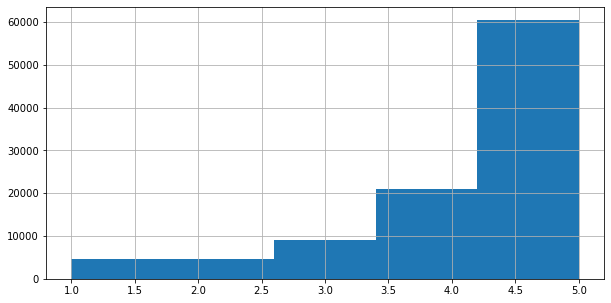

In [8]:
#Histograma y descripción de las calificaciones de data_movies, se observa que la mayoria de las calificaciones son positivas
#sesgo que se debe tener en cuenta al realizar cualquier tipo de analisis.
data_movies=movies_tv['overall']
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
data_movies.hist(bins = 5)
print(data_movies.describe())

count    37126.00000
mean         4.20953
std          1.11855
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: overall, dtype: float64


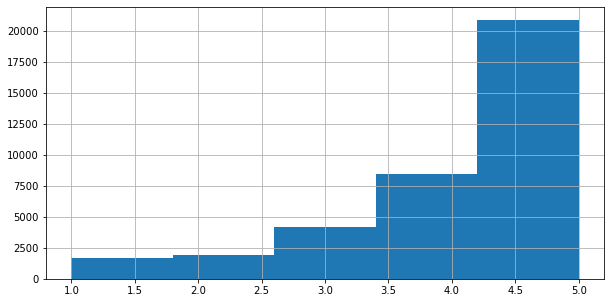

In [9]:
#Histograma y descripción de las calificaciones de data_instant_video, se observa que la mayoria de las calificaciones
#son positivas y presentan un sesgo que se debe tener en cuenta al realizar cualquier tipo de analisis.
data_instant_video=instant_video['overall']
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
data_instant_video.hist(bins = 5)
print(data_instant_video.describe())

<h4>1.2</h4>
<p>How do average ratings change over time? Plot the average rating for each year and note any trends.</p>

**Answer.**

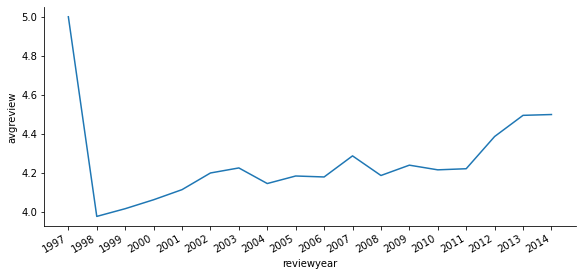

In [9]:
# con el campo DATE adicionamos una columna que muestre el año en la reseña, con el fin de validar las tendencias.
import seaborn as sns
movies_tv['reviewyear'] = movies_tv.datetime.dt.to_period('Y').astype(str)

review_x_year = movies_tv.groupby(by='reviewyear').overall.mean().reset_index(name="avgreview")

trend = sns.relplot(x='reviewyear', y= "avgreview", kind="line", data=review_x_year , height = 4, aspect = 2)
trend.fig.autofmt_xdate()

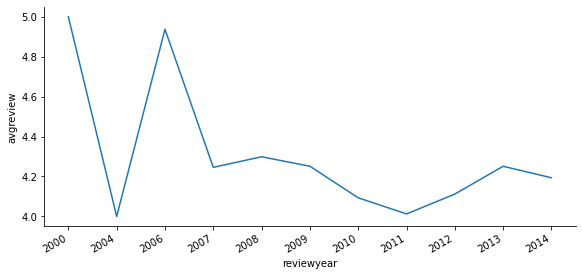

In [10]:
instant_video['reviewyear'] = instant_video.datetime.dt.to_period('Y').astype(str)

review_x_year = instant_video.groupby(by='reviewyear').overall.mean().reset_index(name="avgreview")

trend = sns.relplot(x='reviewyear', y= "avgreview", kind="line", data=review_x_year , height = 4, aspect = 2)
trend.fig.autofmt_xdate()

<h4>1.3</h4>
<p>Look at the average length of the review by year. Do you notice any trends?</p>

**Answer.**

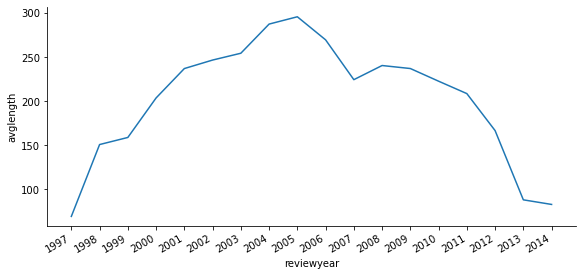

In [11]:
#validamos el tamaño de las reseñas para cada dataset y los agregamos a una nueva columna.

movies_tv['avglength'] = movies_tv.reviewText.apply(lambda x: len(nltk.word_tokenize(x)))

#agrupamos por años, para ver la tendencia en el tamaño de las reseñas

avglength_x_year = movies_tv.groupby(by='reviewyear').avglength.mean().reset_index(name="avglength")

trend_avglength = sns.relplot(x='reviewyear', y= "avglength", kind="line", data=avglength_x_year , height = 4, aspect = 2)
trend_avglength.fig.autofmt_xdate()

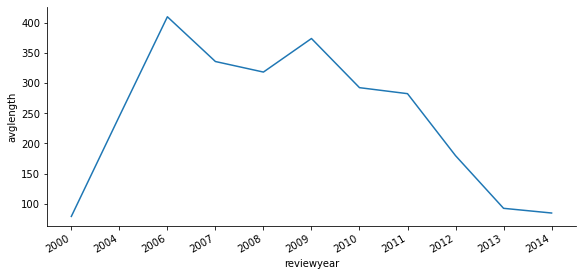

In [12]:
#validamos el tamaño de las reseñas para cada dataset y los agregamos a una nueva columna.

instant_video['avglength'] = instant_video.reviewText.apply(lambda x: len(nltk.word_tokenize(x)))

#agrupamos por años, para ver la tendencia en el tamaño de las reseñas

avglength_x_year = instant_video.groupby(by='reviewyear').avglength.mean().reset_index(name="avglength")

trend_avglength = sns.relplot(x='reviewyear', y= "avglength", kind="line", data=avglength_x_year , height = 4, aspect = 2)
trend_avglength.fig.autofmt_xdate()

***After validating the distribution of the ratings and their trends over time for the two datasets, it is observed that they are very similar not only in relation to the ratings, but also that they maintain the same trend in the number of words used.***

***Given the high consumption of resources, from now on we will only work with the 100,000 records extracted from movies_tv, since it shows less abrupt trends in the behavior of the ratings and the number of words over time, for reviews made by customers .***

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?</p>

**Answer.**

In [13]:
#Se crea una funcion para clasificar los reseñas de acuerdo al numero de estrellas <=2 Negativas, 3 Neutras y =>4 Positivas
#utilizo el mètodo DataFrame.apply para apllicarlo a cada columna del dataframe 

def classreview(stars):
    if stars <= 2 :
        return 'Negative'
    elif stars == 3:
        return 'Neutral'
    else:
        return 'Positive'
    
movies_tv['classreview']= movies_tv.overall.apply(classreview)
movies_tv
#Se generan dos nuevos dataset, uno con los textos para las reseñas positivas y otro para las reseñas negativas

print('***************Negative Review***************')
movies_tv_neg = movies_tv[(movies_tv['classreview'] == 'Negative')].reviewText
print(movies_tv_neg.head(5))

print('***************Positive Review***************')
movies_tv_pos = movies_tv[(movies_tv['classreview'] == 'Positive')].reviewText
print(movies_tv_pos.head(5))


***************Negative Review***************
20     We began watching this video, but stopped it a...
47     This is a first for me, I didn't like this mov...
73     Another entry in the retelling of the classic....
139    This film is closer to the Biblical text of th...
186    The acting was good, the story was correct, bu...
Name: reviewText, dtype: object
***************Positive Review***************
0    This is a charming version of the classic Dick...
3    Henry Winkler is very good in this twist on th...
4    This is one of the best Scrooge movies out.  H...
5    This has been a favorite movie of mine for a l...
6    This is the American adaptation of the Charles...
Name: reviewText, dtype: object


In [15]:
#Se importa de nltk la libreria que contiene la lista de stopwords

nltk.download('stopwords')
from nltk.corpus import stopwords
import re, string # para extraer los signos de puntuacion

# defino una funcion para reemplazar los signos de puntuación y filtrar las palabras de parada

def filter_stopwords(text):
    without_stopwords = []
    stop_words = set(stopwords.words("english"))
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    words = nltk.word_tokenize(text)
    for word in words:
        if word in stop_words:
            pass
        else: 
            without_stopwords.append(word)
    return without_stopwords

# defino una funcion para listar las n palabras mas comunes en un corpus

def top_freq(corpus,n=10):
    return Counter(corpus).most_common(n)

# aplico la función de filtrado de stopwords a todas las reseñas y visualizo las 10 palabras mas comunes

movies_tv_all = ' '.join(movies_tv.reviewText)
movies_tv_without_stopwords_all = filter_stopwords(movies_tv_all)
word_freq = top_freq(movies_tv_without_stopwords_all)
print(word_freq)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guerr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('I', 224733), ('movie', 142837), ('The', 137208), ('film', 116173), ('one', 75661), ('It', 54695), ('This', 53521), ('like', 47278), ('quot', 44715), ('good', 41642)]


In [16]:
# aplico la función de filtrado de stopwords a las reseñas negativas y visualizo las 10 palabras mas comunes
movies_tv_neg_all = ' '.join(movies_tv_neg)
movies_tv_neg_without_stopwords_all = filter_stopwords(movies_tv_neg_all)
word_freq_neg = top_freq(movies_tv_neg_without_stopwords_all)
print(word_freq_neg)

[('I', 27913), ('movie', 15750), ('The', 12773), ('film', 10693), ('one', 6996), ('like', 6139), ('quot', 5348), ('It', 5217), ('This', 4461), ('would', 4045)]


In [17]:
# aplico la función de filtrado de stopwords a las reseñas positivas y visualizo las 10 palabras mas comunes
movies_tv_pos_all = ' '.join(movies_tv_pos)
movies_tv_pos_without_stopwords_all = filter_stopwords(movies_tv_pos_all)
word_freq_pos = top_freq(movies_tv_pos_without_stopwords_all)
print(word_freq_pos)

[('I', 171188), ('movie', 112855), ('The', 109096), ('film', 92358), ('one', 61529), ('This', 44778), ('It', 43812), ('great', 35643), ('like', 35226), ('quot', 34366)]


***The results are surprising since the same words appear in both negative and positive reviews, which makes analysis difficult.***

<h4>2.2</h4>
<p>Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and <em>not</em> in good reviews. What are these words and are they surprising?</p>

**Answer.**

In [21]:
# Utilizo la funcion set para eliminar las palabras repetidas en las reseñas positivas y negativas.

movies_tv_word_neg = set(movies_tv_neg_without_stopwords_all)
movies_tv_word_pos = set(movies_tv_pos_without_stopwords_all)

print(len(movies_tv_word_neg))
print(len(movies_tv_word_pos))

words_only_neg=[]
for word in movies_tv_word_neg:
    if word in movies_tv_word_pos:
        pass
    else:
        words_only_neg.append(word)
print(words_only_neg[:100])
print(len(words_only_neg))

54504
151185
['flapjacks', '0Mbps', 'suggestivemedia', 'gurning', 'Rhein', 'muchmore', 'x0', 'Streak83', 'Edsel', 'ascribing', 'commentng', 'Dahlmer', 'thanwe', 'Ternardiers', 'crapfest', 'Trys', 'WASTED', 'AirPort', 'shirlyn', 'chressy', 'sterero', 'immages', '104mins', 'totalitarianists', 'Medeival', 'externalized', 'goyische', 'KEENEN', 'dragonette', 'ASNers', 'Charnin', 'Pfff', 'cheeeeeky', 'wupposed', 'PARTES', 'paralyze', 'ite', 'ammusement', 'recken', 'Pitiful', 'Vitti', 'Norwwegian', 'RPD', 'obsoleted', 'inapproporaite', 'THERAPY', 'wrongheadedness', 'backstabs', 'Shankely', 'effrects', 'DreamsSweet', 'Morn', '15the', 'smallrole', 'craftsy', 'Godzillla', 'ROTATION', 'whatLaughton', 'snore', 'Honsetly', 'Tomatos', 'trods', 'Occasions', 'counterfundamentalist', 'larked', 'experements', 'ORGAN', 'Trips', 'itAllright', 'prioritise', 'MAAND', 'unbrilliantly', 'STANK', 'honry', 'DISTRIBUTION', 'PLAYERTHE', 'DROUGH', 'supersede', 'Brunvand', 'Hahahahahah', 'KEIFER', 'Glorfies', 'Night

***In negative reviews approximately 10,000 words are used that are not found in positive reviews, some words are: sorry, wrong, outdated, Dreamsweet, inappropriate.***

<h3>Exercise 3:</h3>
<p>Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?</p>

**Answer.**

In [44]:
#filtramos las reseñas negativas que tiene good y visualizamos las 10 primeras
movies_tv_neg_nsw = movies_tv_neg.apply(filter_stopwords)
reviews_containing_good = [item for item in movies_tv_neg_nsw if 'good' in item]
for review in reviews_containing_good[:20]:
    good_index = review.index("good")
    review_with_good = review[good_index-5:good_index+5]
    print(review_with_good)

[]
[]
['needs', 'edited', 'cleaned', 'Theseare', 'simple', 'good', 'vs', 'evil', 'stories', 'happy']
['would', 'least', 'made', 'interesting', 'story', 'good', 'plot', 'character', 'development', 'agree']
['I', 'seen', 'thus', 'far', 'resemble', 'good', 'cinema', 'shape', 'form', 'manner']
['beautifully', 'filmed', 'The', 'acting', 'quite', 'good', 'history', 'freak', 'I', 'found']
['I', 'speaking', 'film', 'critique', 'damage', 'good', 'And', 'anyone', 'else', 'find']
['I', 'say', 'film', 'nowhere', 'near', 'good', 'idolatrous', 'fan', 'base', 'would']
['old', 'religious', 'practices', 'tried', 'turn', 'good', 'Christians', 'America', 'toward', 'side']
['movie', 'A', 'boring', 'movie', 'First', 'good', 'parts', 'I', 'thought', 'using']
['provides', 'nothing', 'makes', 'us', 'feel', 'good', 'uplifting', 'benefit', 'except', 'maybe']
['even', 'person', 'Christ', 'The', 'flashbacks', 'good', 'I', 'rather', 'watched', 'watched']
['fails', 'explain', 'singled', 'Christ', 'symbol', 'good', 

***The word "good" appears in the reviews as they are by nature constructive and not destructive.
In essence, the human being tends to rescue the positive aspects of things and then compare them with their expectations, before generating value judgments. For those reviews with the word "good" the context must be validated.***

<h3>Exercise 4:</h3>
<p>Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:</p>
<ol>
<li>The first word after "good"</li>
<li>The first word after "good" that is a noun or cardinal</li>
<li>The last word before "good" that is a noun or cardinal</li>
</ol>

**Answer.**

In [54]:
# The first word after "good"
for review in reviews_containing_good[:20]:
    good_index = review.index("good")
    review_with_good = review[(good_index+1)]
    print(review_with_good) 

story
scene
vs
plot
cinema
history
And
idolatrous
Christians
parts
uplifting
I
shallow
show
review
guy
majority
interesting
man
feeling


In [122]:
# The first word after "good" that is a noun or cardinal
#nltk.pos_tag(text)
#'JJ'is abjective
#'NN' is noun
#'CD' is cardinal number
for review in reviews_containing_good[:20]:
    review_tag = nltk.pos_tag(review)
    good_index = review.index("good")
    for i in range (good_index,len(review_tag),1):
        if review_tag[i][1] == 'NN' or review_tag[i][1] == 'CD':
            print(review_tag[i])
            break

('story', 'NN')
('scene', 'NN')
('vs', 'NN')
('plot', 'NN')
('cinema', 'NN')
('history', 'NN')
('anyone', 'NN')
('fan', 'NN')
('side', 'NN')
('film', 'NN')
('benefit', 'NN')
('movie', 'NN')
('shallow', 'NN')
('show', 'NN')
('review', 'NN')
('guy', 'NN')
('majority', 'NN')
('interesting', 'NN')
('man', 'NN')
('feeling', 'NN')


In [126]:
# The last word before "good" that is a noun or cardinal
for review in reviews_containing_good[:20]:
    review_tag = nltk.pos_tag(review)
    good_index = review.index("good")
    for i in range (good_index,0,-1):
        if review_tag[i][1] == 'NN' or review_tag[i][1] == 'CD':
            print(review_tag[i])
            break

('transfer', 'NN')
('statement', 'NN')
('story', 'NN')
('everything', 'NN')
('movie', 'NN')
('damage', 'NN')
('film', 'NN')
('turn', 'NN')
('movie', 'NN')
('nothing', 'NN')
('person', 'NN')
('symbol', 'NN')
('pain', 'NN')
('film', 'NN')
('1', 'CD')
('movie', 'NN')
('everyone', 'NN')
('movie', 'NN')
('evangelist', 'NN')


<h3>Exercise 5:</h3>
<p>We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.</p>

**Answer.**

In [128]:
# Utilizamos la funcion para obtener ngrams de "n" elementos y nos muestre los "k" gramas mas comunes 

from nltk.util import ngrams

def top_k_ngrams(word_tokens,n,k):
    
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))

    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(most_common_k)
    
   # x_pos = [k for k,v in most_common_k]
   # y_pos = [v for k,v in most_common_k]
    
   # plt.bar(x_pos, y_pos,align='center')

In [136]:
%%time
#Top de bigramas para las revisiones positivas

print ('*************************POSITIVE REVIEW*********************')
print ('Bigramas más comunes:')
print (top_k_ngrams(movies_tv_pos_without_stopwords_all, 2, 10))
print ()
print ('Trigramas más comunes:')
print (top_k_ngrams(movies_tv_pos_without_stopwords_all, 3, 10))

*************************POSITIVE REVIEW*********************
Bigramas más comunes:
[('This movie', 9141), ('I think', 7958), ('movie I', 7426), ('The film', 5288), ('The movie', 5201), ('I love', 4971), ('I would', 4654), ('This film', 4498), ('I seen', 4346), ('one best', 4258)]
None

Trigramas más comunes:
[('I ever seen', 1677), ('I highly recommend', 1277), ('I love movie', 1103), ('I first saw', 970), ('first time I', 936), ('I would recommend', 760), ('Tommy Lee Jones', 751), ('I saw movie', 750), ('I seen movie', 593), ('I think I', 583)]
None
Wall time: 47.3 s


In [137]:
%%time
#Top de bigramas para las revisiones negativas

print ('*************************NEGATIVE REVIEW*********************')
print ('Bigramas más comunes:')
print (top_k_ngrams(movies_tv_neg_without_stopwords_all, 2, 10))
print ()
print ('Trigramas más comunes:')
print (top_k_ngrams(movies_tv_neg_without_stopwords_all, 3, 10))

*************************NEGATIVE REVIEW*********************
Bigramas más comunes:
[('This movie', 1148), ('movie I', 1117), ('I think', 994), ('I would', 771), ('I know', 706), ('The movie', 631), ('I like', 578), ('I thought', 553), ('film I', 543), ('special effects', 534)]
None

Trigramas más comunes:
[('I ever seen', 241), ('I know I', 117), ('I think I', 100), ('I guess I', 87), ('Tommy Lee Jones', 86), ('I wish I', 81), ('movies I ever', 74), ('I thought I', 73), ('I saw movie', 73), ('The special effects', 73)]
None
Wall time: 1min 57s
Compiler : 143 ms


<h3>Exercise 6:</h3>
<p>Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.</p>

**Answer.**

The objective is to always place an adjective that accompanies a noun, which will allow us to analyze the context of the sentence in a better way.

The steps to follow are:

A function is defined where the input is a text:

1. A filter_stopwords () function is applied to the text that tokenizes the text and removes words_stop and punctuation.
2. The tag is added to the tokenized words that come out of the filter
3. It is validated if the words are adjective or noun and two lists are generated without repeated words
4. Adjective and noun are mixed iteratively

<h3>Exercise 7:</h3>
<p>Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return <code>["good movie", "long movie"]</code>.</p>

**Answer.**

In [188]:
"""
Se define una funcion donde la entrada es un texto:
1. Al texto se le aplica una funcion filter_stopwords() que tokeniza el texto y elimina words_stop y puntuacion.
2. Se agrega el tag a las palabras tokenizadas que salen del filtro
3. Se valida si las palabras son adjective o noun y se generan dos listas sin palabras repetidas
4. Se mezclan adjective y noun de forma iterativa 
"""

def adjetive_noun(text):
    adject = []
    noun = []
    words_important=[]
    type_adjective=['JJ','JJR','JJS','RB']
    token_list = filter_stopwords(text)
    tags = nltk.pos_tag(token_list)
    for tag in tags:
        if tag[1] in type_adjective:
            adject.append(tag[0])
        elif tag[1] == 'NN':
            noun.append(tag[0])
        else:
            pass
     
    adject = list(set(adject))   
    noun = list(set(noun))
    
    for elem in adject:
        for i in range (0,len(noun)):
            words_important.append(elem +' '+ noun[i])                
    print('************ TAGs ************\n')    
    print(tags)
    print('\n')
    print('************ ADJECTIVES ************\n') 
    print(adject)
    print('\n')
    print('************ NOUN ************\n') 
    print(noun)
    print('\n')
    print('************ IMPORTANT WORDS ************\n')
    print(words_important)
    print('\n')
    
    
sentence = "That was a good, long movie, bad movie, not good"
adjetive_noun(sentence)

************ TAGs ************

[('That', 'DT'), ('good', 'JJ'), ('long', 'JJ'), ('movie', 'NN'), ('bad', 'JJ'), ('movie', 'NN'), ('good', 'NN')]


************ ADJECTIVES ************

['bad', 'long', 'good']


************ NOUN ************

['good', 'movie']


************ IMPORTANT WORDS ************

['bad good', 'bad movie', 'long good', 'long movie', 'good good', 'good movie']


